# Requirements


## Header

- Keyword that clearly indicates whether the image is a MASK_IN, MASK_OUT or CHECK

# hoy

- Added testing to Public API
- 2100_5577A solo 3 lineas
- mask position characterization slightly more complicated than initially thought

# Imports

In [232]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import subprocess

from astropy.coordinates import SkyCoord, Angle, match_coordinates_sky
from astropy.io.fits.header import Header
from astropy.modeling import models, fitting
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astroquery.gaia import Gaia
from ccdproc import CCDData
from photutils import DAOStarFinder
from threading import Timer


from goodman_pipeline.core import ra_dec_to_deg
from goodman_pipeline.core import SaturationValues

# Class Definition

In [251]:
def kill_process(process):
    print('Sextractor timed out')
    process.kill()

class AlignSlitToTarget(object):
    
    def __init__(self, pixel_scale_arcsec=0.15, detect_with='sextractor', dark=True):
        self.pixel_scale = Angle(pixel_scale_arcsec, u.arcsec)
        self.detect_with = detect_with
        self.scale = ZScaleInterval()
        self.serial_binning = 1
        self.parallel_binning = 1
        self.x_crpix_offset = 0 #40
        self.y_crpix_offset = 0# 50
        self.background_level = 0
        
        self.wcs = WCS(naxis=2)
        self.reference_catalog = None
        self.reference_sources = None
        self.detected_sources = None
        self.detected_sources_sky = None
        
        self.spherical_offsets = None
        
        if dark:
            plt.style.use('dark_background')
    
    def __call__(self, ccd):
        ## CCDSUM
        
        self.serial_binning, self.parallel_binning = [int(x) for x in ccd.header['CCDSUM'].split()]
        self.__get_box_shape(ccd)
        ccd = self._add_default_astrometric_solution(ccd)
        
        # find sources
        
        sources = self.detect_sources(ccd)
        self.__query_gaia_async(ccd)
        self.wcs = self.get_wcs_solution(ccd)
        ccd.wcs = self.wcs
        ccd.write('result.fits', overwrite=True)
        self.__show_with_wcs_overlay(ccd)
        
    def detect_sources(self, ccd):
        if self.detect_with == 'sextractor':
            self.__detect_with_sextractor(ccd)
            return 0
        elif self.detect_with == 'daostarfinder':
            return self.__detect_with_dao_star_find(ccd)
        else:
            raise NotImplementedError(f"Detection method {self.detect_with} is not implemented")

    def get_wcs_solution(self, ccd):
        if self.detect_with == 'sextractor':
            wcs = self.__get_wcs_solution_with_scamp()
            wcs.array_shape = ccd.data.shape
            return wcs
        else:
            self.__match_sources_detector()
        
        
        
    @staticmethod
    def __ra_dec_to_degrees(ccd):
        """Maybe this can be calculated only once"""
        return ra_dec_to_deg(right_ascension=ccd.header['RA'], declination=ccd.header['DEC'])
    
    def _add_default_astrometric_solution(self, ccd):
        x, y = ccd.data.shape
        ra_deg, dec_deg = self.__ra_dec_to_degrees(ccd)
        self.wcs.wcs.crpix = [x/2. + self.x_crpix_offset, y/2. + self.y_crpix_offset]
        self.wcs.wcs.cdelt = np.array([self.pixel_scale.deg * self.serial_binning, 
                                       self.pixel_scale.deg * self.parallel_binning])
        self.wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        self.wcs.wcs.crval = [ra_deg, dec_deg]
        self.wcs.array_shape = ccd.data.shape
        
        ccd.wcs = self.wcs
        return ccd
    
    def __get_box_shape(self, ccd, plots=False):
        x, y = ccd.data.shape
        x_median = np.median(ccd.data[int(x/2. - 0.2 * x): int(x/2. + 0.2 * x),:], axis=0)
        y_median = np.median(ccd.data[:, int(x/2. - 0.2 * x): int(x/2. + 0.2 * x)], axis=1)

        # fit a box model
        x_box_model = models.Box1D(amplitude=np.max(x_median), x_0=int(x/2.), width=int(x/2.))
        y_box_model = models.Box1D(amplitude=np.max(y_median), x_0=int(y/2.), width=int(y/2.))

        box_fitter = fitting.SimplexLSQFitter()

        x_box_fitted = box_fitter(x_box_model, range(x), x_median)
        y_box_fitted = box_fitter(y_box_model, range(y), y_median)

        if plots:
            fig, (ax1, ax2) = plt.subplots(2, 1 ,figsize=(20,15))
            ax1.set_title('X Axis')
            ax1.plot(x_median)
            ax1.plot(x_box_fitted(range(x)), color='r')
            ax2.set_title('Y Axis')
            ax2.plot(y_median)
            ax2.plot(y_box_fitted(range(y)), color='r')
            plt.show()
            
        self.x_width = x_box_fitted.width.value * (self.serial_binning * self.pixel_scale)
        self.y_width = y_box_fitted.width.value * (self.parallel_binning * self.pixel_scale)

        self.background_level = (x_box_fitted.amplitude.value + y_box_fitted.amplitude.value) / 2.
    
    
    
    def __query_gaia_async(self, ccd):
        ra_deg, dec_deg = self.__ra_dec_to_degrees(ccd)
        sky_coord = SkyCoord(ra=ra_deg, dec=dec_deg, unit=(u.degree, u.degree), frame='icrs')
        width = u.Quantity(self.x_width, u.deg)
        height = u.Quantity(self.y_width, u.deg)
#         print(width, height)
        Gaia.ROW_LIMIT = -1
        self.reference_catalog = Gaia.query_object_async(coordinate=sky_coord, 
                                                         width=width, 
                                                         height=height)
    
        self.reference_sources = SkyCoord(self.reference_catalog['ra'],
                                          self.reference_catalog['dec'],
                                          unit=(u.degree, u.degree), 
                                          frame='icrs')
#         self.reference_catalog.pprint()
    @staticmethod
    def call_subproces(command):
        print(command)
        try:
            sub_process = subprocess.Popen(command.split(),
                                           stdout=subprocess.PIPE, 
                                           stderr=subprocess.PIPE)
        except OSError as error:
            print(error)
        
        process_timer = Timer(10, kill_process, [sub_process])
        try:
            #     sex_timer.start()
            stdout, stderr = sub_process.communicate()
        finally:
            process_timer.cancel()
    
        if stdout != b'': 
            print(stdout)
        if stderr != b'':
            print(stderr.decode('utf-8'))
    
        
    def __detect_with_sextractor(self, ccd):
        
        temp_file_name = 'temp_file.fits'
        ccd.write(temp_file_name, overwrite=True)
        mean, median, std = sigma_clipped_stats(ccd.data, sigma=3.0)
        

        saturation_values = SaturationValues()
        
        catalog_name = "sample.cat" ## OK
        catalog_type = "FITS_LDAC"
        threshold_type = 'ABSOLUTE' ## OK
        detection_threshold = 3. * std
        pixels_above_threshold = 6
        # pixels_below_threshold = 50
        seeing_fwhm = ccd.header['SEEING'] # 5 * serial_binning ## OK
        if seeing_fwhm < 0:
            seeing_fwhm *= -1
        
        # background
        background_type='MANUAL' ##  OK
        background_value = self.background_level ## OK
        
        gain = ccd.header['GAIN'] ## OK
        pixel_scale = 0.15 * self.serial_binning # arcsec ## OK
        saturation_level = saturation_values.get_saturation_value(ccd)
        parameters_file = 'data/case_1/default.param'
        
        # print(ccd.header['CCDSUM'])
        
        command = f"sex {temp_file_name} "\
                  f" -CATALOG_NAME {catalog_name}"\
                  f" -CATALOG_TYPE {catalog_type}"\
                  f" -PARAMETERS_NAME {parameters_file} "\
                  f" -DETECT_THRESH {detection_threshold} "\
                  f" -DETECT_MINAREA {pixels_above_threshold} "\
                  f" -THRESH_TYPE {threshold_type}"\
                  f" -FILTER N"\
                  f" -GAIN {gain}"\
                  f" -BACK_TYPE {background_type}"\
                  f" -BACK_VALUE {background_value}"\
                  f" -SEEING_FWHM {seeing_fwhm}"\
                  f" -PIXEL_SCALE {pixel_scale}"\
                  f" -SATUR_LEVEL {saturation_level}"

                  # f" -DETECT_MAXAREA {pixels_below_threshold} "\
                  # f" -CATALOG_TYPE {catalog_type}"\

        self.call_subproces(command=command)
        
        # remove file just created
    
    def __detect_with_dao_star_find(self, ccd):
        
        # mask everything and mask out boxed area
        mean, median, std = sigma_clipped_stats(ccd.data, sigma=3.0)
        daofind = DAOStarFinder(fwhm=3.0, threshold=5. * std)
        sources = daofind(ccd.data - median)
        for col in sources.colnames:
            sources[col].info.format = '%.8g'        
        self.detected_sources = sources
        ra_ = sources['xcentroid']
        dec = sources['ycentroid']
        self.detected_sources_sky = pixel_to_skycoord(ra_, dec, self.wcs)
        
    def __match_sources_detector(self):
        idx, d2d, d3d = match_coordinates_sky(self.detected_sources_sky, self.reference_sources)
        matches = self.reference_sources[idx]
        self.spherical_offsets = self.detected_sources_sky.spherical_offsets_to(matches)
        
    def __get_wcs_solution_with_scamp(self):
        catalog_name = "sample.cat"
        astrometric_reference_catalog = 'GAIA-DR2'
        
        scamp_command = f"scamp {catalog_name} -ASTREF_CATALOG {astrometric_reference_catalog}"
        self.call_subproces(scamp_command)
        
        head_file = open('sample.head', 'r')
        lines = head_file.readlines()
        wcs_lines = lines[3:17]
        wcs_lines.append(lines[-1])
        wcs_string = ''.join(wcs_lines)
        hdr = Header.fromstring(wcs_string)
        new_wcs = WCS(hdr)
        return new_wcs

        
    
        
        
    def __show_with_wcs_overlay(self, ccd):
        
        fig  = plt.figure(figsize=(16,16))
        ax = plt.subplot(projection=ccd.wcs)

        plt.imshow(ccd.data, clim=self.scale.get_limits(ccd), origin='lower', cmap='cividis')
        ax.plot(self.reference_sources.ra.deg, 
                self.reference_sources.dec.deg, 
                'o', 
                color='g',
                mfc='none',
                markersize=12, 
                transform=ax.get_transform('icrs'),
                label='Gaia')
        if self.detected_sources is not None:
            ax.plot(self.detected_sources_sky.ra.deg, 
                    self.detected_sources_sky.dec.deg, 
                    'o', 
                    color='r',
                    mfc='none',
                    markersize=12, 
                    transform=ax.get_transform('icrs'),
                    label="Detected")
        ax.set_xlabel(r'RA')
        ax.set_ylabel(r'DEC')
        ax.legend(loc='best')
        
        overlay = ax.get_coords_overlay('icrs')
        overlay.grid(color='white', ls='dotted')
        
        plt.show()
          

In [252]:
align_slit = AlignSlitToTarget()

In [253]:
mask_out_file_1 = 'data/case_1/0350_SN2020uxz-23-10-2020_mask_out.fits'
mask_out_file_2 = 'data/case_1/0347_SN2020uxz-23-10-2020_mask_out.fits'
mask_out_file_3 = 'data/case_2/0357_REFITT-ZTF20ackfpcb-09-11-2020_mask_out.fits'

ccd_1 = CCDData.read(mask_out_file_1, unit='adu')
ccd_2 = CCDData.read(mask_out_file_2, unit='adu')
ccd_3 = CCDData.read(mask_out_file_3, unit='adu')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


sex temp_file.fits  -CATALOG_NAME sample.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME data/case_1/default.param  -DETECT_THRESH 2865.1992303645015  -DETECT_MINAREA 6  -THRESH_TYPE ABSOLUTE -FILTER N -GAIN 1.48 -BACK_TYPE MANUAL -BACK_VALUE 2586.275009100055 -SEEING_FWHM 0.613 -PIXEL_SCALE 0.3 -SATUR_LEVEL 69257.0

> WARNING: default.sex not found, using internal defaults

> 
----- SExtractor 2.25.0 started on 2021-03-02 at 13:07:49 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for temp_file.fits
----- Measuring from: temp_file.fits
      "SN2020uxz" / no ext. header / 1548x1548 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at l

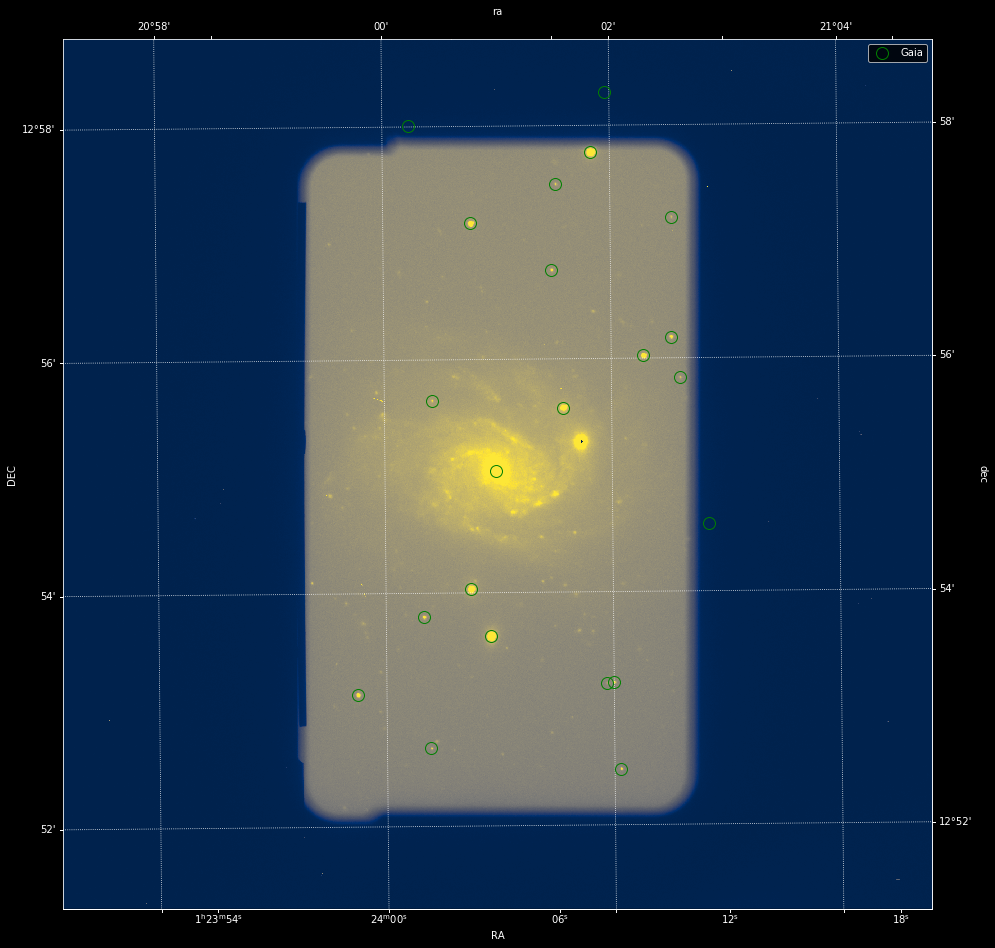

In [254]:
align_slit(ccd=ccd_1)

sex temp_file.fits  -CATALOG_NAME sample.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME data/case_1/default.param  -DETECT_THRESH 2785.880921268567  -DETECT_MINAREA 6  -THRESH_TYPE ABSOLUTE -FILTER N -GAIN 1.48 -BACK_TYPE MANUAL -BACK_VALUE 2494.6290421445046 -SEEING_FWHM 0.634 -PIXEL_SCALE 0.3 -SATUR_LEVEL 69257.0

> WARNING: default.sex not found, using internal defaults

> 
----- SExtractor 2.25.0 started on 2021-03-02 at 13:08:01 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for temp_file.fits
----- Measuring from: temp_file.fits
      "SN2020uxz" / no ext. header / 1548x1548 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at l

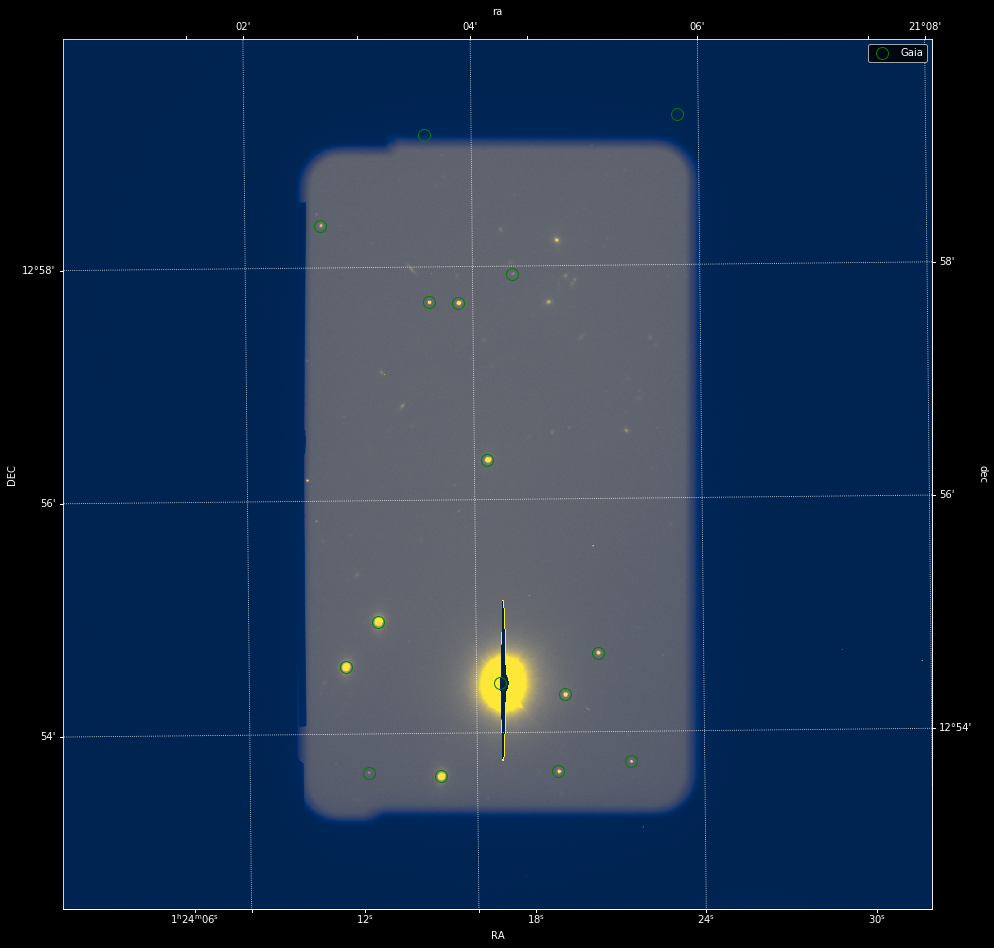

In [255]:
align_slit(ccd=ccd_2)

sex temp_file.fits  -CATALOG_NAME sample.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME data/case_1/default.param  -DETECT_THRESH 2773.7774176733537  -DETECT_MINAREA 6  -THRESH_TYPE ABSOLUTE -FILTER N -GAIN 1.48 -BACK_TYPE MANUAL -BACK_VALUE 2481.706893063413 -SEEING_FWHM 1.0 -PIXEL_SCALE 0.3 -SATUR_LEVEL 69257.0

> WARNING: default.sex not found, using internal defaults

> 
----- SExtractor 2.25.0 started on 2021-03-02 at 13:08:13 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for temp_file.fits
----- Measuring from: temp_file.fits
      "ZTF20ackfpcb" / no ext. header / 1548x1548 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at 

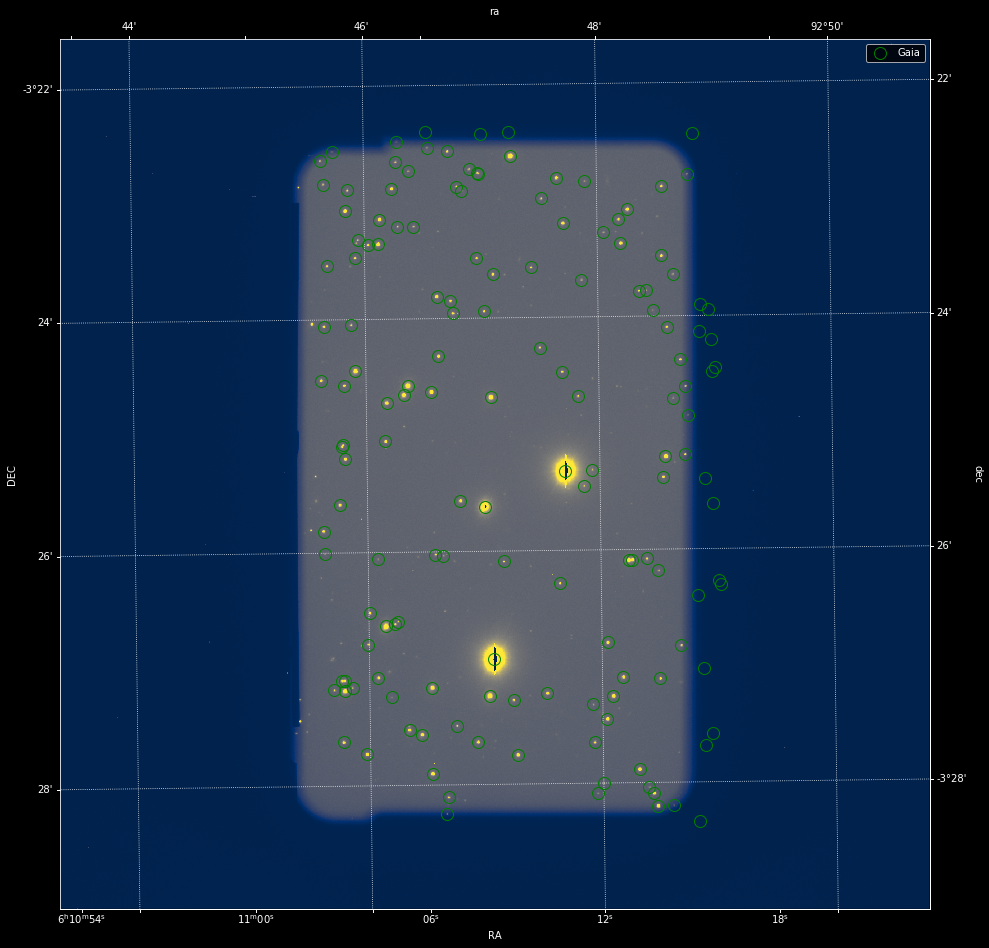

In [256]:
align_slit(ccd=ccd_3)

In [257]:
file_3_1 = 'data/case_3/0042_Knight_C.fits'
file_3_2 = 'data/case_3/0050_Knight_21P_VR_x4_BLUE_19-02-2021.fits'

ccd31 = CCDData.read(file_3_1, unit='adu')
ccd32 = CCDData.read(file_3_2, unit='adu')


sex temp_file.fits  -CATALOG_NAME sample.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME data/case_1/default.param  -DETECT_THRESH 786.1206980921447  -DETECT_MINAREA 6  -THRESH_TYPE ABSOLUTE -FILTER N -GAIN 1.4 -BACK_TYPE MANUAL -BACK_VALUE 1019.7646967515353 -SEEING_FWHM 1.0 -PIXEL_SCALE 0.3 -SATUR_LEVEL 49928.0

> WARNING: default.sex not found, using internal defaults

> 
----- SExtractor 2.25.0 started on 2021-03-02 at 13:08:26 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for temp_file.fits
----- Measuring from: temp_file.fits
      "C/2019 E3" / no ext. header / 1548x1548 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line

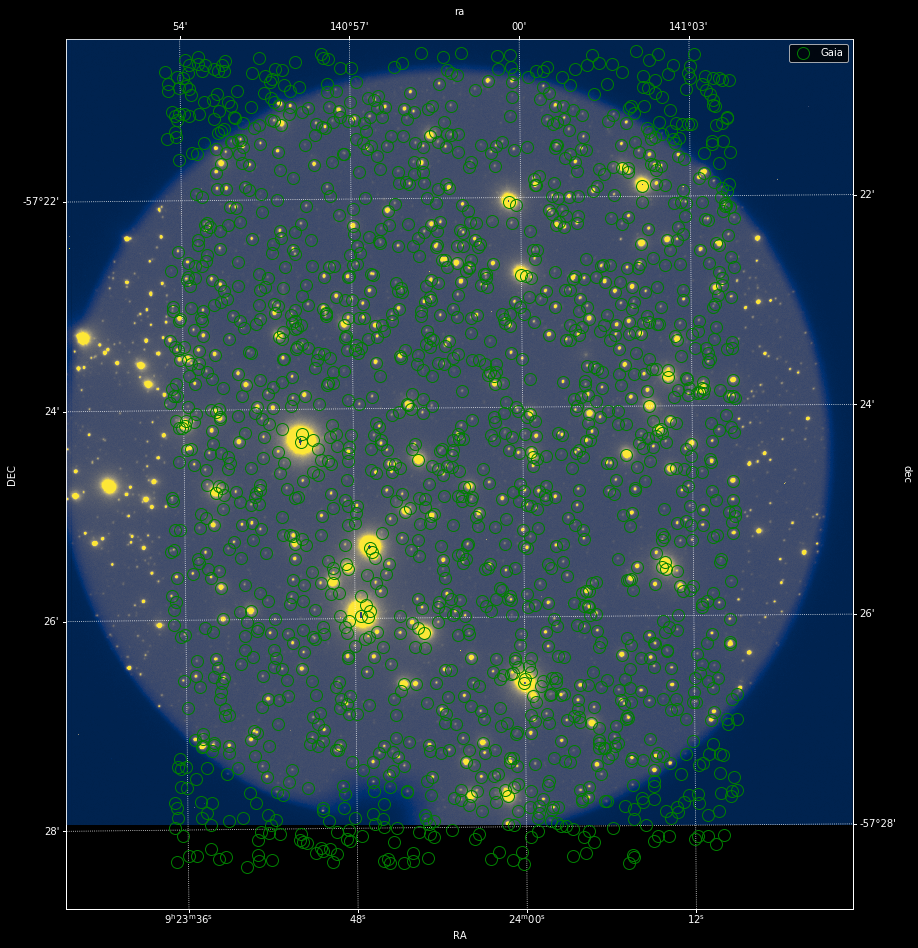

In [258]:
align_slit(ccd31)

sex temp_file.fits  -CATALOG_NAME sample.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME data/case_1/default.param  -DETECT_THRESH 4264.878262198021  -DETECT_MINAREA 6  -THRESH_TYPE ABSOLUTE -FILTER N -GAIN 1.4 -BACK_TYPE MANUAL -BACK_VALUE 3786.2576461528333 -SEEING_FWHM 1.0 -PIXEL_SCALE 0.3 -SATUR_LEVEL 49928.0

> WARNING: default.sex not found, using internal defaults

> 
----- SExtractor 2.25.0 started on 2021-03-02 at 13:08:49 with 1 thread

> Setting catalog parameters
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing catalog
> Looking for temp_file.fits
----- Measuring from: temp_file.fits
      "21P" / no ext. header / 1548x1548 / 16 bits (integers)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384

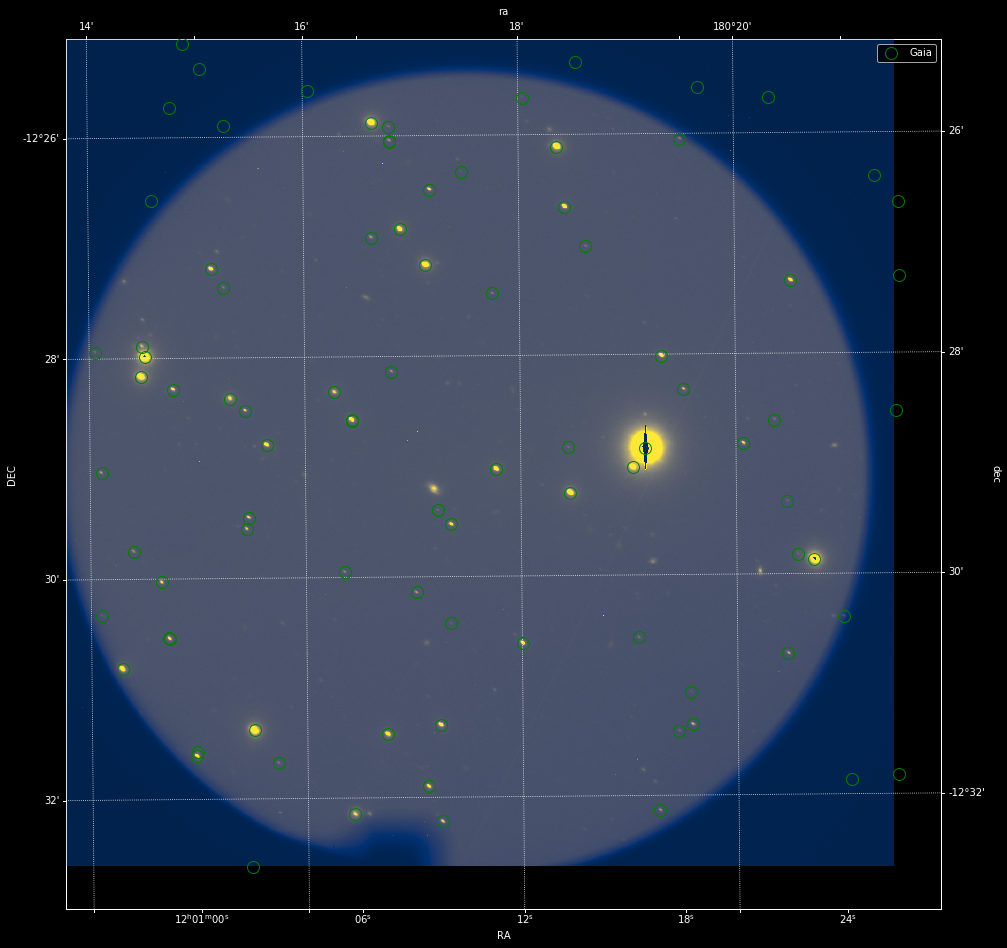

In [259]:
align_slit(ccd32)

# TripleSpec Experiment

N up and E left. The coordinates toward top of screen are 05:08:58 -68:43:18. Pixel scale is ~0.26"/pix. 


In [260]:
tspec_slit_align = AlignSlitToTarget(pixel_scale_arcsec=0.26)
tspec_pixel_scale = Angle(0.26, u.arcsec)
tspec_sv_image = 'data/tpsec_sv/SV_OBJ0021.fits'
ccd_sv = CCDData.read(tspec_sv_image, unit='adu')
ccd_sv.header

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   16 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  940                                                  
NAXIS2  =                  940                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
NEXTEND =                    0 / Number of extensions                           
OBJECT  = 'none    '           / object title                                   
PROPID  = 'NA      '           / propose ID                                     
OBSID   = 'obs.20210225.235212' / sequence ID                                   
FILENAME= 'SV_OBJ0021.fits'    / fits file name                                 
EXPID   = 'ct4m.tspec.202102

In [261]:
x, y = ccd_sv.data.shape
ra_deg, dec_deg = ra_dec_to_deg(right_ascension=ccd_sv.header['RA'], declination=ccd_sv.header['DEC'])
print(ccd_sv.header['RA'])
print(ccd_sv.header['DEC'])
print(ra_deg, dec_deg)
wcs = WCS(naxis=2)
wcs.wcs.crpix = [x/2., y]
wcs.wcs.cdelt = np.array([-tspec_pixel_scale.deg, tspec_pixel_scale.deg])
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcs.wcs.crval = [ra_deg, dec_deg]
wcs.array_shape = ccd_sv.data.shape
       
ccd_sv.wcs = wcs
# ccd_sv = tspec_slit_align._add_default_astrometric_solution(ccd=ccd_sv)
ccd_sv.write('tspec_1.fits', overwrite=True)

05:08:56.454
-68:43:15.270
77.235225 -68.72090833333333


In [265]:


sky_coord = SkyCoord(ra=ra_deg, dec=dec_deg, unit=(u.degree, u.degree), frame='icrs')
x_width = 940 * tspec_pixel_scale 
y_width = 940 * tspec_pixel_scale 
print(x_width, y_width)
width = u.Quantity(x_width, u.deg)
height = u.Quantity(y_width, u.deg)
#         print(width, height)
Gaia.ROW_LIMIT = -1
reference_catalog = Gaia.query_object_async(coordinate=sky_coord, 
                                            width=width, 
                                            height=height)
    
reference_sources = SkyCoord(reference_catalog['ra'],
                             reference_catalog['dec'],
                             unit=(u.degree, u.degree), 
                             frame='icrs')

244.4arcsec 244.4arcsec
INFO: Query finished. [astroquery.utils.tap.core]


In [266]:
reference_sources

<SkyCoord (ICRS): (ra, dec) in deg
    [(77.23534343, -68.72110605), (77.23461197, -68.72169373),
     (77.23277898, -68.72177683), ..., (77.20459543, -68.68709761),
     (77.26782288, -68.68727807), (77.20158196, -68.68699586)]>

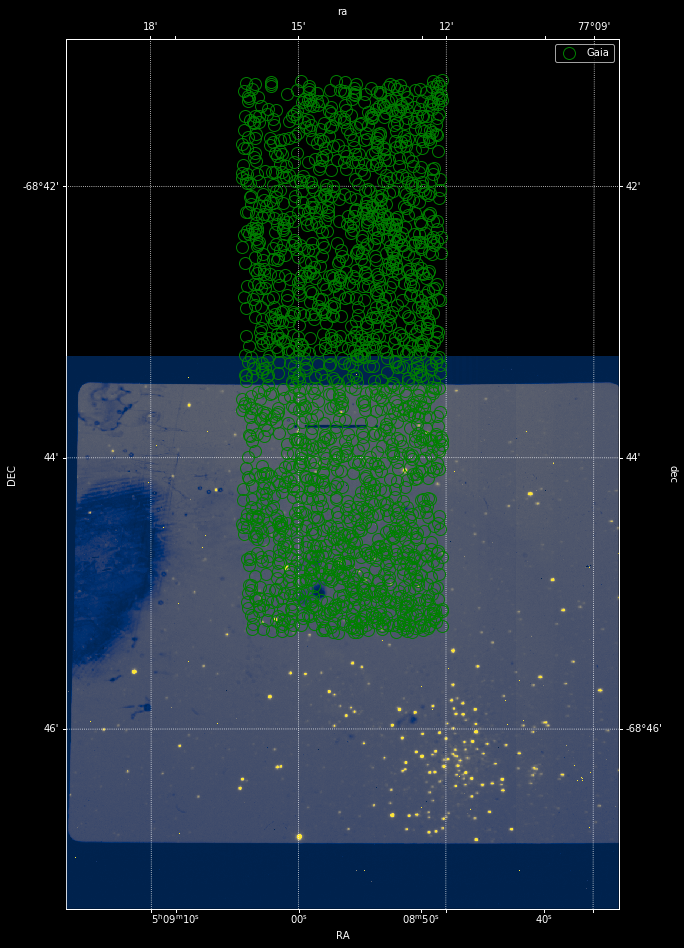

In [267]:


fig  = plt.figure(figsize=(16,16))
ax = plt.subplot(projection=ccd_sv.wcs)
scale = ZScaleInterval()

plt.imshow(ccd_sv.data, clim=scale.get_limits(ccd_sv), origin='lower', cmap='cividis')
ax.plot(reference_sources.ra.deg, 
        reference_sources.dec.deg, 
        'o', 
        color='g',
        mfc='none',
        markersize=12, 
        transform=ax.get_transform('icrs'),
        label='Gaia')
#         if self.detected_sources is not None:
#             ax.plot(self.detected_sources_sky.ra.deg, 
#                     self.detected_sources_sky.dec.deg, 
#                     'o', 
#                     color='r',
#                     mfc='none',
#                     markersize=12, 
#                     transform=ax.get_transform('icrs'),
#                     label="Detected")
ax.set_xlabel(r'RA')
ax.set_ylabel(r'DEC')
ax.legend(loc='best')
       
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
        
plt.show()

In [203]:
ccd_sv.data.shape

(940, 940)